pt_classifer takes SiPM response maps and for each map (time slice)  and uses a neural network to determine how many hits there were in the EL plane.

In [1]:
from keras.models               import Sequential
from keras.layers               import Dense, Activation, Dropout
from keras.optimizers           import SGD, Adam, Nadam         
from keras                      import callbacks
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core          import Flatten

%matplotlib inline

import numpy as np
import tables as tb
import matplotlib.pyplot as plt

# data filename should contain SiPM maps for 1,2, ..., max_hits
data_filename = 'TMC_data.h' 
max_hits = 2 # (up to 4)

nsipm = 8


Using Theano backend.
/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Load data

In [2]:
f = tb.open_file('TMC_data.h','r')
h1_train = f.root.sim_1pt.xtrain
h1_valid = f.root.sim_1pt.xvalid

h2_train = f.root.sim_2pt.xtrain  
h2_valid = f.root.sim_2pt.xvalid 

#h3_train = f.root.sim_3pt.xtrain
#h3_valid = f.root.sim_3pt.xvalid
    
One_Hot_Encoding = True # set to true for one hot encoded labels
def organize(hits):
    # input organize your training data as a list of numpy arrays (or earrays)
    # organize outputs your training matrix of SiPM maps and their one hot encoded labels
    
    length = sum([pt.shape[0] for pt in hits])
    x = np.array(hits)
    x = x.reshape((length,h1_train.shape[1]))
    
    y = np.array([np.ones(pt.shape[0],np.int) * i for pt,i in zip(hits,range(1,len(hits)+1))])
    y = y.reshape((length))
    
    if One_Hot_Encoding:
        yh = np.zeros((length,len(hits)),np.int)
        i=0
        for numhits in y:
            yh[i,numhits-1] = 1
            i+=1
        return(x,yh)
    
    return x,y

# important to note these are unshuffled, but they will be shuffled during training so it should be fine
#x_train,y_train = organize([h1_train,h2_train,h3_train])
x_train,y_train = organize([h1_train,h2_train])
x_valid,y_valid = organize([h1_valid,h2_valid])
#x_valid,y_valid = organize([h1_valid,h2_valid,h3_valid])


Define some networks:

In [6]:
# construct a 5 layer network

def cnn():
    model = Sequential()
 
    # **Worth taking into consideration that our image size is tiny (8x8), convolution may work much better for 
    # **with 1792 sipms
    
    # kernal size is 3x3, 32 filters
    model.add(Convolution2D(32,3,3,border_mode='same',input_shape=(1, nsipm, nsipm)))
    model.add(Activation('relu'))
    model.add(Convolution2D(32,3,3,border_mode='same', input_shape=(32, nsipm, nsipm)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(output_dim=128))
    model.add(Activation('relu'))      
    model.add(Dense(output_dim=64))
    model.add(Activation('relu'))  
    model.add(Dense(max_hits))
    model.add(Activation('sigmoid'))

    # Nadam optimizer is a safe choice at least for deep networks. It is adam optimizer with Nesterov
    # Momentum. Nesterov Momentum takes into account future expected future gradient gradient, unlike traditional Mom.
    model.compile(loss='mse', optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004),
                  metrics=['accuracy'])
    N_layers = 'cnn'
    return model,N_layers
    

def lay5():
    model = Sequential()
    model.add(Dense(output_dim=2048, input_dim=nsipm*nsipm))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=1024))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=512))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=256))
    model.add(Activation("relu"))
    model.add(Dropout(.25))    # **Note this is drop rate, not keep rate (like in tf)
    model.add(Dense(output_dim=max_hits))
    model.add(Activation("sigmoid"))
    
    # Nadam optimizer is probabaly a safe choice at least for our deep networks. It is adam optimizer with Nesterov
    # Momentum. Nesterov Momentum takes into account future expected future gradient gradient, unlike traditional Mom.
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))
    model.summary()
    N_layers = 'cnn'
    return model,N_layers
    
# construct a 4 layer network
def lay4():
    model = Sequential()
    model.add(Dense(output_dim=2048, input_dim=nsipm*nsipm))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=1024))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=512))
    model.add(Activation("relu"))
    model.add(Dropout(.2))
    model.add(Dense(output_dim=max_hits))
    model.add(Activation("sigmoid"))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))
    model.summary()
    N_layers = 4
    return model,N_layers
    
# etc .. 
def lay3():
    model = Sequential()
    model.add(Dense(output_dim=2048, input_dim=nsipm*nsipm))
    model.add(Activation("relu"))
    model.add(Dense(output_dim=1024))
    model.add(Activation("relu"))
    #model.add(Dropout(.15))
    model.add(Dense(output_dim=max_hits))
    model.add(Activation("sigmoid"))
    #model.compile(loss='mse', optimizer=SGD(lr=1.0, momentum=0.9, nesterov=True))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))

    model.summary()
    N_layers = 3
    return model,N_layers

def lay2():
    model = Sequential()
    model.add(Dense(output_dim=2048, input_dim=nsipm*nsipm))
    model.add(Activation("relu"))
    #model.add(Dropout(.25))
    model.add(Dense(output_dim=max_hits))
    model.add(Activation("softmax"))
    model.compile(loss ='categorical_crossentropy',  optimizer=SGD(lr=1.0, momentum=0.9, nesterov=True))
    #model.compile(loss='mse', optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))
    model.summary()
    N_layers = 2
    return model,N_layers
    
def lay1():
    model = Sequential()
    model.add(Dense(output_dim=max_hits, input_dim=nsipm**2))
    model.add(Activation("softmax"))
    model.compile(loss ='categorical_crossentropy',  optimizer=SGD(lr=1.0, momentum=0.9, nesterov=True))
    model.summary()
    N_layers = 1
    return model,N_layers


Call a network and begin training

In [7]:
# call desired network
model,N_layers = cnn()

# stop early and save best model
ES = False
Save_model = False
if ES and Save_model:
    callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min'), # stop training if val_loss 
                                                                             # stops decreasing for 3 epochs
        
        callbacks.ModelCheckpoint(ES_filepath, monitor='val_loss', save_best_only=True, mode='min')] # save best model
# stop early do not save    
elif ES:
    callbacks =[callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')]

# do not stop early, decide whether to save later *use this when comparing error of different numbers of layers
else: callbacks =[]

if N_layers == 'cnn':
    hist = model.fit(x_train.reshape((y_train.shape[0],1,nsipm,nsipm)), y_train, nb_epoch=30, batch_size=100,  
                 validation_data=(x_valid.reshape((y_valid.shape[0],1,nsipm,nsipm)),y_valid),
                 verbose=2, callbacks=callbacks);  
else:
    hist = model.fit(x_train, y_train, nb_epoch=5, batch_size=100,  
                 validation_data=(x_valid,y_valid),
                 verbose=2, callbacks=callbacks); 

Train on 20000 samples, validate on 2000 samples
Epoch 1/30
5s - loss: 0.0727 - acc: 0.9048 - val_loss: 0.0331 - val_acc: 0.9610
Epoch 2/30
5s - loss: 0.0348 - acc: 0.9589 - val_loss: 0.0232 - val_acc: 0.9745
Epoch 3/30
5s - loss: 0.0255 - acc: 0.9712 - val_loss: 0.0291 - val_acc: 0.9665
Epoch 4/30
5s - loss: 0.0221 - acc: 0.9752 - val_loss: 0.0189 - val_acc: 0.9800
Epoch 5/30
10s - loss: 0.0204 - acc: 0.9767 - val_loss: 0.0221 - val_acc: 0.9770
Epoch 6/30
5s - loss: 0.0207 - acc: 0.9767 - val_loss: 0.0398 - val_acc: 0.9560
Epoch 7/30
9s - loss: 0.0221 - acc: 0.9755 - val_loss: 0.0174 - val_acc: 0.9815
Epoch 8/30
10s - loss: 0.0171 - acc: 0.9813 - val_loss: 0.0162 - val_acc: 0.9825
Epoch 9/30
9s - loss: 0.0176 - acc: 0.9800 - val_loss: 0.0176 - val_acc: 0.9815
Epoch 10/30
12s - loss: 0.0165 - acc: 0.9822 - val_loss: 0.0216 - val_acc: 0.9750
Epoch 11/30
7s - loss: 0.0157 - acc: 0.9827 - val_loss: 0.0162 - val_acc: 0.9825
Epoch 12/30
9s - loss: 0.0164 - acc: 0.9817 - val_loss: 0.0159 - v

Determine accuracy:

In [8]:
# Get model's predictions, plot the error in a histogram
if N_layers == 'cnn':
    predictions = model.predict(x_valid.reshape((y_valid.shape[0],1,nsipm,nsipm)))
else: 
    predictions = model.predict(x_valid)

count = 0.0 
for p,t in zip(predictions,y_valid):

    if np.argmax(p) == np.argmax(t): 
        count +=1.0
print('accuracy: ' + str(count/y_valid.shape[0]*100) + '%' )
print('correct: ' + str(count))
print('total: '   + str(y_valid.shape[0]))

accuracy: 98.7%
correct: 1974.0
total: 2000


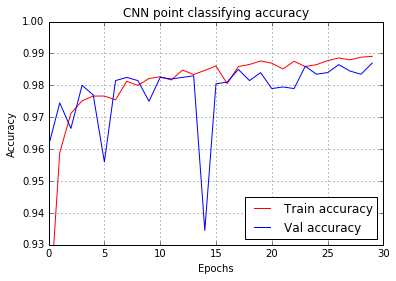

In [15]:
train = plt.plot(range(0,len(hist.history['loss'])),
                 np.array(hist.history['acc']), 'r', label='Train accuracy')
val   = plt.plot(range(0,len(hist.history['loss'])),
                 np.array(hist.history['val_acc']), 'b', label='Val accuracy')
plt.ylim([.93,1])
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN point classifying accuracy')
plt.grid(True)
plt.show()

This CNN has less than half the error of the 5layer DNN, after fewer epochs! It also takes less time/epoch to run than the 5 layer net!